<a href="https://colab.research.google.com/github/w15d0177/AIFFEL_project/blob/main/Keras/keras_customized_metric_callback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **사용자 정의 지표 만들기: fit() 메소드가 출력하는 진행 표시줄에 RMSE 값 확인**




In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

def get_mnist_model():
  """
  Defines and returns a simple Keras model for MNIST.
  """
  model = keras.models.Sequential([
      keras.layers.Flatten(input_shape=(28, 28)),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(10, activation='softmax')
  ])
  return model

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Pre-process the data: normalize pixel values to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Create a validation set (e.g., using 10% of the training data)
val_images = train_images[:6000]
val_labels = train_labels[:6000]
train_images = train_images[6000:]
train_labels = train_labels[6000:]


model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8856 - loss: 0.4197 - val_accuracy: 0.9608 - val_loss: 0.1388
Epoch 2/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9614 - loss: 0.1299 - val_accuracy: 0.9667 - val_loss: 0.1131
Epoch 3/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9723 - loss: 0.0944 - val_accuracy: 0.9748 - val_loss: 0.0894
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9664 - loss: 0.1110


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

def get_mnist_model():
  """
  Defines and returns a simple Keras model for MNIST.
  """
  model = keras.models.Sequential([
      keras.layers.Flatten(input_shape=(28, 28)),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(10, activation='softmax')
  ])
  return model

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Pre-process the data: normalize pixel values to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Create a validation set (e.g., using 10% of the training data)
val_images = train_images[:6000]
val_labels = train_labels[:6000]
train_images = train_images[6000:]
train_labels = train_labels[6000:]


model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8794 - loss: 0.4333 - rmse: 0.4250 - val_accuracy: 0.9575 - val_loss: 0.1479 - val_rmse: 0.2533
Epoch 2/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9626 - loss: 0.1290 - rmse: 0.2404 - val_accuracy: 0.9668 - val_loss: 0.1151 - val_rmse: 0.2265
Epoch 3/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9748 - loss: 0.0855 - rmse: 0.1971 - val_accuracy: 0.9727 - val_loss: 0.0873 - val_rmse: 0.2000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9698 - loss: 0.1060 - rmse: 0.2153


# **사용자 정의 콜백 만들기: 손실 그래프를 저장하는 사용자 정의 콜백의 출력 확인**

In [ ]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8803 - loss: 0.4286 - val_accuracy: 0.9587 - val_loss: 0.1435
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9610 - loss: 0.1309 - val_accuracy: 0.9655 - val_loss: 0.1072
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9714 - loss: 0.0952 - val_accuracy: 0.9708 - val_loss: 0.0936
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9785 - loss: 0.0725 - val_accuracy: 0.9695 - val_loss: 0.0953
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9825 - loss: 0.0594 - val_accuracy: 0.9748 - val_loss: 0.0798
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9858 - loss: 0.0495 - val_accuracy: 0.9745 - val_loss: 0.0836
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9888 - loss: 0.0425 - val_accuracy: 0.9738 - val_loss: 0.0955
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9890 - loss: 0.03

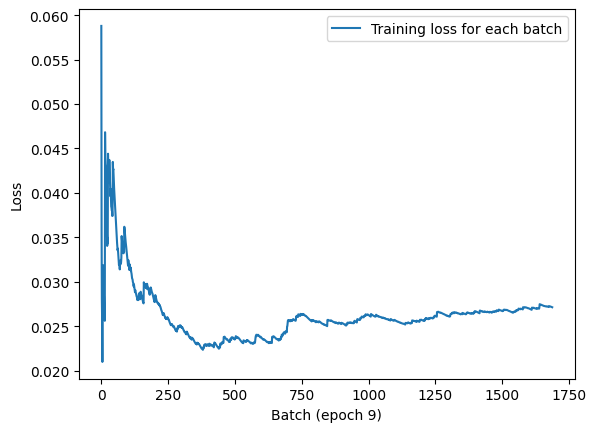

In [ ]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

이 그래프는 모델의 학습 손실(Training loss)을 배치(batch) 단위로 표시한 것입니다.
- X축: 배치의 순서(또는 학습의 진행 단계)
- Y축: 해당 배치에서 계산된 손실 값


1. 초기 손실 감소: 그래프의 초반에는 손실 값이 빠르게 감소하고 있습니다. 이는 모델이 학습 초기 단계에서 데이터에 대한 패턴을 빠르게 학습하고 있다는 것을 보여줍니다.

2. 손실 안정화: 이후 배치가 진행됨에 따라 손실 값이 점차 안정화되고 있습니다. 이 부분에서는 모델이 더 이상 크게 개선되지 않고 손실이 낮은 값을 유지하는 상태에 도달한 것을 의미합니다.

3. 경미한 손실 증가: 그래프 끝부분에서 손실이 약간 증가하는 모습이 보입니다. 이는 모델이 오버피팅되기 시작했거나, 학습률이 안정적이지 않아서 나타날 수 있는 현상입니다.

결론적으로, 이 그래프는 모델이 훈련 중에 손실을 점진적으로 줄여가는 과정과 어느 정도 학습이 완료되어 손실이 수렴하는 상태를 잘 보여줍니다.

# **레이어 변경**

## 레이어를 깊게 변경

In [1]:
import tensorflow as tf
from tensorflow import keras

def get_deeper_mnist_model():
    """
    Defines and returns a deeper convolutional neural network model for MNIST.
    """
    model = keras.models.Sequential([
        # 첫 번째 합성곱 레이어
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D((2, 2)),

        # 두 번째 합성곱 레이어
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),

        # 세 번째 합성곱 레이어
        keras.layers.Conv2D(128, (3, 3), activation='relu'),

        # 특성 맵을 평탄화하여 Dense 레이어에 연결
        keras.layers.Flatten(),

        # 추가된 밀집 레이어
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),  # 과적합 방지

        # 출력 레이어
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

# 모델 생성 및 컴파일
model = get_deeper_mnist_model()
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# MNIST 데이터셋 로드 및 전처리
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

# 이미지를 CNN에 적합한 형상으로 변경
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

# 검증 세트 생성
val_images, val_labels = train_images[:6000], train_labels[:6000]
train_images, train_labels = train_images[6000:], train_labels[6000:]

# 모델 훈련
model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

# 테스트 데이터로 평가
test_metrics = model.evaluate(test_images, test_labels)
print("Test accuracy:", test_metrics[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 67s 36ms/step - accuracy: 0.8598 - loss: 0.4325 - val_accuracy: 0.9848 - val_loss: 0.0530
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 77s 34ms/step - accuracy: 0.9815 - loss: 0.0644 - val_accuracy: 0.9882 - val_loss: 0.0385
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.9862 - loss: 0.0460 - val_accuracy: 0.9850 - val_loss: 0.0488
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 85s 35ms/step - accuracy: 0.9893 - loss: 0.0346 - val_accuracy: 0.9900 - val_loss: 0.0360
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 55s 32ms/step - accuracy: 0.9931 - loss: 0.0238 - val_accuracy: 0.9898 - val_loss: 0.0387
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - accuracy: 0.9930 - loss: 0.0228 - val_accuracy: 0.9917 - val_loss: 0.0317
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.9945 - loss: 0.0179 - val_accuracy: 0.9890 - val_loss: 0.0412
Epoch 8/10
1688/1688 ━━━━

1. **특성 추출 (Feature Extraction)**
레이어가 깊어질수록 모델은 점점 더 복잡한 패턴과 높은 수준의 특징을 추출할 수 있습니다.
초기 레이어들은 저수준의 특징(예: 가장자리, 색상)을 학습하는 반면, 깊은 레이어들은 고수준의 특징(예: 물체의 형태, 복잡한 패턴)을 학습하게 됩니다.
예를 들어, MNIST와 같은 숫자 이미지 분류 문제에서 초기 레이어는 숫자의 선이나 곡선을 학습하고, 더 깊은 레이어는 숫자의 전체 형태를 학습하여 최종적으로 어떤 숫자인지 분류하게 됩니다.
2. **정보 축소 및 요약 (Information Reduction and Abstraction)**
각 레이어를 통과하면서 입력 데이터는 더 압축되고, 중요한 특징들만 남게 됩니다. 이는 정보의 추상화(abstraction) 과정이라고 볼 수 있습니다.
깊은 레이어일수록 입력 데이터의 저수준 세부 정보를 제거하고, 학습된 중요한 패턴이나 특징만을 남기게 됩니다.
3. **표현력 향상 (Expressive Power Increase)**
깊은 신경망은 더 많은 수의 매개변수를 가지며, 복잡한 데이터의 비선형 패턴을 더 잘 모델링할 수 있습니다.
이러한 높은 표현력 덕분에, 모델은 이미지, 텍스트, 음성과 같은 다양한 데이터의 복잡한 패턴을 학습하는 데 적합합니다.
그러나 지나치게 깊은 레이어는 학습이 어려워질 수 있으며, 오버피팅(overfitting)이 발생할 가능성도 있습니다. 이를 방지하기 위해 정규화(regularization) 기법이나 드롭아웃(dropout)과 같은 방법을 사용할 수 있습니다.
4. **추상화 수준 (Level of Abstraction)**
초기 레이어는 입력 데이터의 작은 부분을 보고 개별적인 픽셀 간 관계를 학습합니다.
중간 레이어는 저수준 특징을 결합하여 더 높은 수준의 패턴을 인식합니다.
깊은 레이어에서는 입력 전체를 기반으로 학습된 고수준의 패턴을 바탕으로 데이터의 의미적 구성을 이해하고, 최종적으로 더 정교한 예측을 할 수 있습니다.
5. **디버깅과 학습 시간 증가**
레이어가 깊어질수록 모델의 학습 시간이 늘어날 수 있습니다. 복잡한 신경망 구조는 더 많은 계산 리소스를 요구하며, 학습 속도도 느려질 수 있습니다.
또한, 심층 네트워크는 기울기 소실(vanishing gradient) 문제나 기울기 폭발(exploding gradient) 문제에 직면할 수 있어 학습이 어려워질 수 있습니다.
이러한 문제를 해결하기 위해 배치 정규화(batch normalization), 잔차 연결(residual connections) 등과 같은 기법을 사용하는 것이 일반적입니다.
이처럼 레이어가 깊어질수록 모델은 데이터의 복잡한 특징을 더 잘 학습할 수 있는 능력을 가지지만, 동시에 학습의 안정성 및 속도와 관련된 문제도 발생할 수 있습니다.

## 레이어를 넓게 변경

In [ ]:
import tensorflow as tf
from tensorflow import keras

def get_wider_mnist_model():
    """
    Defines and returns a wider convolutional neural network model for MNIST.
    """
    model = keras.models.Sequential([
        # 첫 번째 합성곱 레이어 - 필터 수를 늘려 넓힘
        keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D((2, 2)),

        # 두 번째 합성곱 레이어 - 필터 수를 늘려 넓힘
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),

        # 세 번째 합성곱 레이어 - 필터 수를 늘려 넓힘
        keras.layers.Conv2D(256, (3, 3), activation='relu'),

        # 특성 맵을 평탄화하여 Dense 레이어에 연결
        keras.layers.Flatten(),

        # 넓은 Dense 레이어 추가
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),  # 과적합 방지

        # 출력 레이어
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

# 모델 생성 및 컴파일
model = get_wider_mnist_model()
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# MNIST 데이터셋 로드 및 전처리
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

# 이미지를 CNN에 적합한 형상으로 변경
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

# 검증 세트 생성
val_images, val_labels = train_images[:6000], train_labels[:6000]
train_images, train_labels = train_images[6000:], train_labels[6000:]

# 모델 훈련
model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

# 테스트 데이터로 평가
test_metrics = model.evaluate(test_images, test_labels)
print("Test accuracy:", test_metrics[1])


**1.** **더 많은 특성 학습**: 넓은 레이어는 각 레이어에서 더 많은 필터 또는 뉴런을 가지므로, 입력 데이터를 보다 세밀하게 분석하고 더 많은 특징을 학습할 수 있습니다.
이는 특히 복잡한 패턴이 많거나 데이터의 다양한 세부 정보를 학습해야 하는 경우에 유리합니다.


**2.** **계산량 증가**: 필터와 뉴런의 수가 많아지면 그만큼 학습 시 필요한 계산량도 크게 증가합니다. 따라서 훈련 시간이 늘어나고 메모리 사용량도 증가할 수 있습니다.


**3.** **과적합 가능성**: 모델의 학습 능력이 증가하면서 훈련 데이터에 대해 높은 성능을 보일 수 있지만, 과적합이 발생할 가능성도 커집니다. 드롭아웃이나 정규화 기법을 사용하여 과적합을 방지하는 것이 중요합니다.


**4.** **표현력 증가**: 모델의 표현력이 증가하여 다양한 종류의 데이터에 대해 더 복잡한 관계를 학습할 수 있습니다. 그러나 표현력의 증가가 반드시 일반화 성능의 증가로 이어지는 것은 아니므로 데이터에 맞춘 조정이 필요합니다.
이처럼 모델을 "넓히면" 입력 데이터의 다양한 패턴을 더 세밀하게 학습할 수 있지만, 계산 자원이 많이 필요하며 과적합의 위험도 증가합니다.






